### Differential abundance analyses

#### 1. Load required libraries

In [1]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("apeglm")
# install.packages("pheatmap")
library(pheatmap, warn.conflicts = F, quietly = T)
library(ggplot2, warn.conflicts = F, quietly = T)
library(limma, warn.conflicts = F, quietly = T)
library(DESeq2, warn.conflicts = F, quietly = T)
library(edgeR, warn.conflicts = F, quietly = T)
library(Glimma, warn.conflicts = F, quietly = T)
library(apeglm, warn.conflicts = F, quietly = T)

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”

Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Warning message:
“package ‘matrixStats’ was built under R version 4.1.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:


#### 2. Load data

In [2]:
# if you've already run deseq2 -- load environment
# load(".RData")

In [2]:
metadata <- read.table("../03-diff_abundance/map.txt", header=T, sep="\t")
row.names(metadata) <- metadata$sample_id
genecounts <- read.table("ads.read_counts.txt", header=T, sep="\t", row.names = 1)
# fix sample names gene count file
colnames(genecounts) <- gsub(x = names(genecounts), pattern = "X", replacement = "UF")  

#### 3. Format for DESeq2 analysis

In [3]:
# only compare PD to PF
metadata <- metadata[metadata$tooth_type != "PE",]
# only keep columns found in metadata
genecounts <- genecounts[, colnames(genecounts) %in% row.names(metadata)]
# reorder by metadata rownames
metadata <- metadata[order(colnames(genecounts)),]
# colnames(genecounts)
# rownames(metadata)
# create deseq object
star_results <- DESeqDataSetFromMatrix(countData = genecounts, colData = metadata, design = ~tooth_type)
# filter out any genes with fewer than 10 reads total
star_results <- star_results[rowSums(counts(star_results)) >= 10,]
star_results
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results$tooth_type <- factor(star_results$tooth_type, levels=c("PD", "PF"))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 929 60 
metadata(1): version
assays(1): counts
rownames(929): SEQF1003_00728 SEQF1006_00028 ... SEQF3023_01081
  SEQF3030_01756
rowData names(0):
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(10): sample_id tooth_type ... ads_nmol_min_mg_of_protein
  concentration_ng_ul

#### 4. Run DESeq2

In [4]:
ptm <- proc.time()
se_star <- DESeq(star_results)
proc.time() - ptm 
# compute normalized counts (log2 transformed); + 1 is a count added to avoid errors during the log2 transformation: log2(0) gives an infinite number, but log2(1) is 0.
# normalized = TRUE: divide the counts by the size factors calculated by the DESeq function

norm_counts <- log2(counts(se_star, normalized = TRUE)+1)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 384 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



   user  system elapsed 
 16.285   0.827  11.825 

In [5]:
# save.image()
res <- results(se_star, alpha=0.05)
# order by p value
res <- res[order(res$padj),]
paste("number of genes with adjusted p value lower than 0.05: ", sum(res$padj < 0.05, na.rm=TRUE))
summary(res)

[1] "number of genes with adjusted p value lower than 0.05:  427"


out of 920 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 117, 13%
LFC < 0 (down)     : 310, 34%
outliers [1]       : 0, 0%
low counts [2]     : 63, 6.8%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [53]:
resultsNames(se_star)

[1] "Intercept"           "tooth_type_PF_vs_PD"

In [54]:
# filter out low count genes
resLFC <- lfcShrink(se_star, coef="tooth_type_PF_vs_PD", type="apeglm")
resLFC <- resLFC[order(resLFC$padj),]
paste("number of genes with adjusted p value lower than 0.05: ", sum(resLFC$padj < 0.05, na.rm=TRUE))
summary(resLFC)
# write results to file
write.table(resLFC, file="deseq_results.txt", quote=F, sep="\t")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] "number of genes with adjusted p value lower than 0.05:  427"


out of 920 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 123, 13%
LFC < 0 (down)     : 340, 37%
outliers [1]       : 0, 0%
low counts [2]     : 63, 6.8%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [57]:
spcount <- as.data.frame(table(gsub("_.*", "", row.names(resLFC))))
arcABC <- spcount[spcount$Freq >=3,]
dim(arcABC)
write.csv(arcABC, "three_arcgenes.list", quote=FALSE)
# filter gene count table (can compare original to filtered)
system("awk -F','' '{print $2}' three_arcgenes.list | while read line; do grep $line ads.read_counts.txt ; done > ads.filt.read_counts.txt")
system("head -n 1 ads.read_counts.txt > headers")
system("cat headers ads.filt.read_counts.txt > temp")
system("mv temp ads.filt.read_counts.txt")

[1] 176   2

In [68]:
metadata <- read.table("../03-diff_abundance/map.txt", header=T, sep="\t")
row.names(metadata) <- metadata$sample_id
metadata <- metadata[metadata$tooth_type != "PE",]

genefilt <- read.table("ads.filt.read_counts.txt", header=T, sep="\t", row.names = 1)
# fix sample names gene count file
colnames(genefilt) <- gsub(x = names(genefilt), pattern = "X", replacement = "UF")  
genefilt <- genefilt[, colnames(genefilt) %in% row.names(metadata)]
# reorder by metadata rownames
metadata <- metadata[order(colnames(genefilt)),]
head(metadata)
# create deseq object
star_results_filt <- DESeqDataSetFromMatrix(countData = genefilt, colData = metadata, design = ~tooth_type)
# filter out any genes with fewer than 10 reads total
star_results_filt <- star_results_filt[rowSums(counts(star_results_filt)) >= 10,]
star_results_filt
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results_filt$tooth_type <- factor(star_results_filt$tooth_type, levels=c("PD", "PF"))
# run deseq
ptm <- proc.time()
se_star_filt <- DESeq(star_results_filt)
norm_counts <- log2(counts(se_star_filt, normalized = TRUE)+1)


res_filt <- results(se_star_filt, alpha=0.05)
# order by p value
res_filt <- res_filt[order(res_filt$padj),]
paste("number of genes with adjusted p value lower than 0.05: ", sum(res_filt$padj < 0.05, na.rm=TRUE))
summary(res_filt)

,sample_id,tooth_type,individual_id,caries_status,original_sample_id,novaseq_id,volume_used_ul,protein_mg_ml,ads_nmol_min_mg_of_protein,concentration_ng_ul
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
UF106PFR,UF106PFR,PF,B106,CA,B106-PFR,106PFR,80,0.399,17.580,14.46
UF10PD,UF10PD,PD,B10,CA,B10-PD,10PD,120,0.153,8.900,7.74
UF115PD,UF115PD,PD,B115,CA,B115-PD,115PD,120,0.083,20.181,26.51
UF12PD,UF12PD,PD,B12,CA,B12-PD,12PD,80,0.222,16.450,5.29
UF13PF,UF13PF,PF,B13,CF,B13-PF,13PF,40,0.380,58.260,25.43
UF14PF,UF14PF,PF,B14,CF,B14-PF,14PF,40,0.266,55.000,36.07


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 635 60 
metadata(1): version
assays(1): counts
rownames(635): SEQF1003_00728 SEQF1003_00729 ... SEQF2917_01270
  SEQF2917_00968
rowData names(0):
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(10): sample_id tooth_type ... ads_nmol_min_mg_of_protein
  concentration_ng_ul

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 257 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "number of genes with adjusted p value lower than 0.05:  324"


out of 628 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 71, 11%
LFC < 0 (down)     : 253, 40%
outliers [1]       : 0, 0%
low counts [2]     : 7, 1.1%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



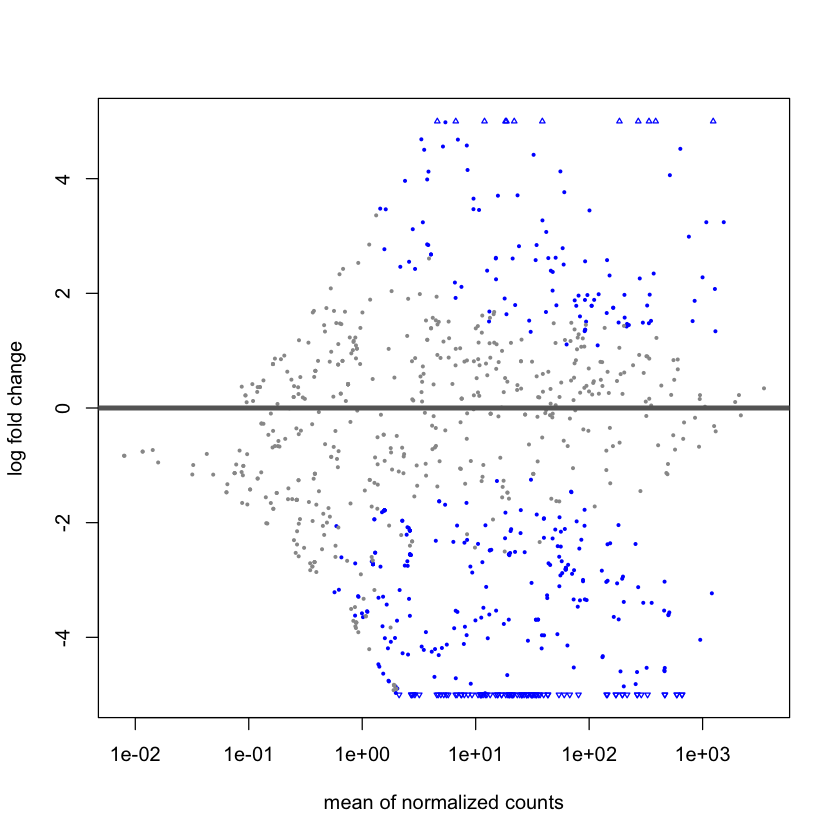

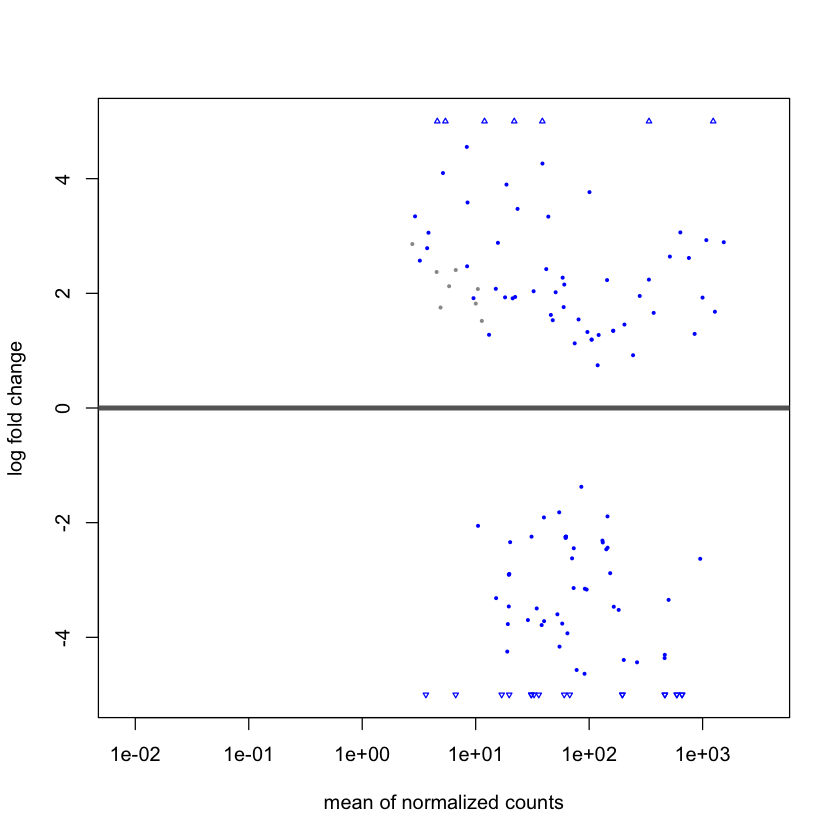

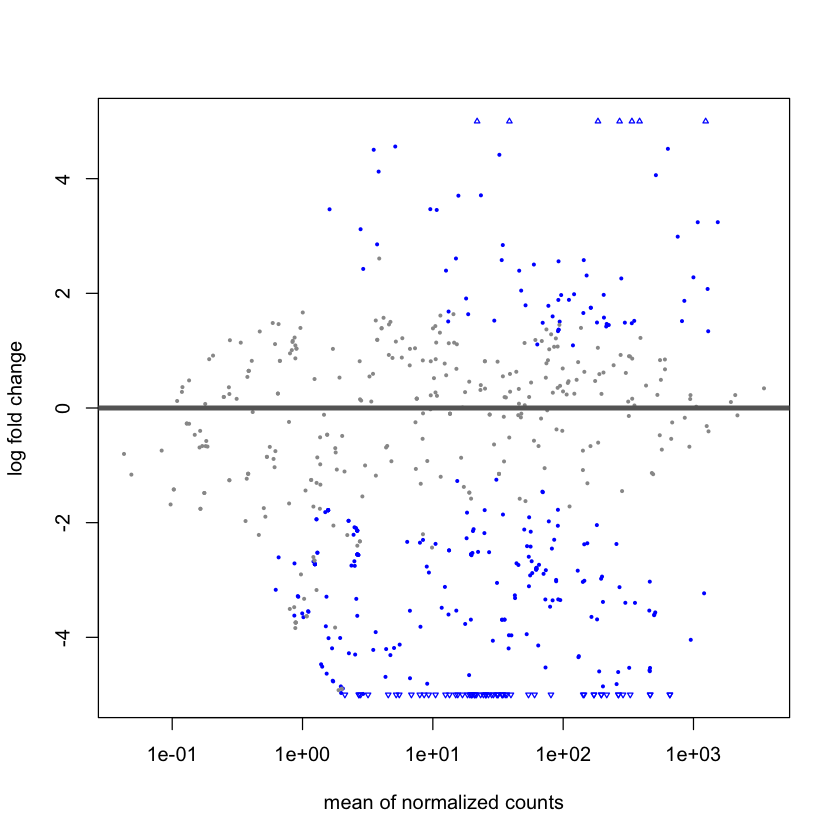

In [69]:
volcano_all <- plotMA(res, ylim=c(-5,5))
plotMA(res, ylim=c(-5,5))
volcano_flat <- plotMA(resLFC, ylim=c(-5,5))
plotMA(resLFC, ylim=c(-5,5))
plotMA(res_filt, ylim=c(-5,5))

In [70]:
# transform for visualizations
vld <- varianceStabilizingTransformation(se_star_filt)

pdf 
  2

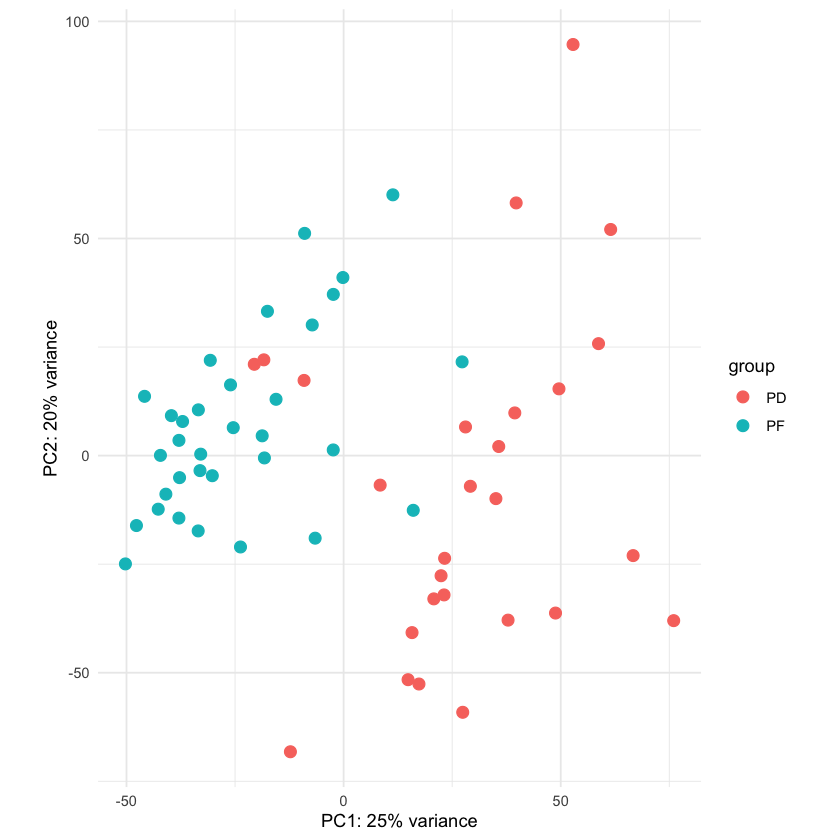

In [76]:
#Get top varying genes
topVarGenes <- head(order(rowVars(assay(vld)), decreasing=TRUE), 100)
 
#make a subset of the log transformed counts for just the top 25 varying genes
topCounts <- assay(vld)[topVarGenes,]
write.csv(topCounts, file="topcounts.vld.csv", quote=FALSE)
 
#PLOT PCA
#PCA using top 500 varying genes
pdf("pca_pdvpf.pdf")
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()
dev.off()
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()

pdf 
  2

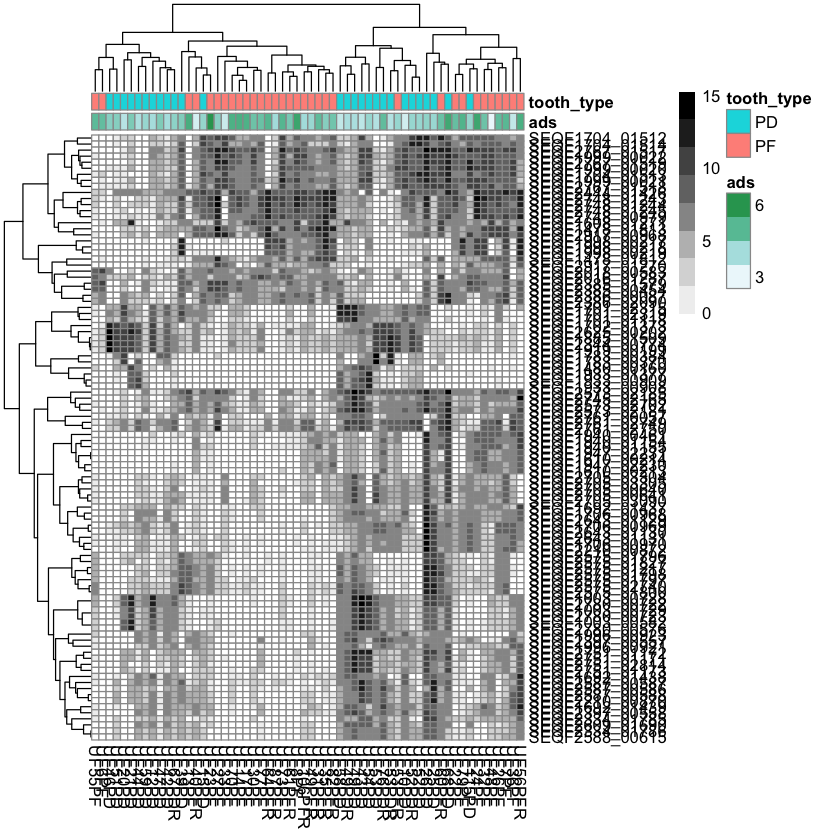

In [77]:
df <- as.data.frame(colData(vld)[,c("ads_nmol_min_mg_of_protein","tooth_type")])
df$ads_nmol_min_mg_of_protein <- log2(as.numeric(df$ads_nmol_min_mg_of_protein))
colnames(df) <- c("ads", "tooth_type")

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
library(RColorBrewer)
x <- pheatmap(topCounts, annotation_col = df, color = brewer.pal(9, "Greys"))
save_pheatmap_pdf(x, "heatmap_ADSpdvpf.pdf")